<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Travel-insurance-prediction" data-toc-modified-id="Travel-insurance-prediction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Travel insurance prediction</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#Fitting-a-models" data-toc-modified-id="Fitting-a-models-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Fitting a models</a></span></li></ul></li></ul></div>

# Travel insurance prediction   
Motivation: Predict Whether A Given Customer Would Like To Buy The Insurance Package, Once The Corona Lockdown Ends And Travelling Resumes.  
Your Work Could Probably Help Save Thousands Of Rupees Of A Family.  

Kaggle link - https://www.kaggle.com/tejashvi14/travel-insurance-prediction-data

In [977]:
import os
import warnings

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cycler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import xgboost as xgb

# Save the default settings if you want to roll back the style you made
IPython_default = plt.rcParams.copy()
%matplotlib inline

In [1014]:
# After loading dataset from Kaggle in your directory
file = [f for f in os.listdir() if f.endswith(".csv")][0]
data = pd.read_csv(file)

## Overview

In [344]:
print(data.shape)
data.head()

(1987, 9)


,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [248]:
data.any().isnull()

Unnamed: 0             False
Age                    False
Employment Type        False
GraduateOrNot          False
AnnualIncome           False
FamilyMembers          False
ChronicDiseases        False
FrequentFlyer          False
EverTravelledAbroad    False
TravelInsurance        False
dtype: bool

In [39]:
data.dtypes

Unnamed: 0              int64
Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

4 qualitative signs, we will transform them in the future

In [40]:
def show_objects(df):
    cols = df.select_dtypes(include=['object']).columns
    for col in cols:
        print("Unique values for {}".format(col))
        print(data.loc[:, col].unique())
    
show_objects(data)

Unique values for Employment Type
['Government Sector' 'Private Sector/Self Employed']
Unique values for GraduateOrNot
['Yes' 'No']
Unique values for FrequentFlyer
['No' 'Yes']
Unique values for EverTravelledAbroad
['No' 'Yes']


Great, object columns have 2 values

## Visualization

From less to more. First, let's look at the linear dependencies

But before that, adjust your style

In [41]:
# Tune style
monokai_black = '#232323'

colors = cycler('color',
                ['#CCCC00','#3399FF','#59f4ff','#884dff', '#4dff62', 
                 '#6f992f', '#ffa230','#ff3030','#545454','#000000']
               )
plt.rc('axes', axisbelow=True, grid=True, titlesize=15,
       prop_cycle=colors, titlecolor='white', labelcolor='white')
plt.rc('figure', figsize=(16,6), facecolor='#232323')
plt.rc('xtick', direction='out', color='white')
plt.rc('ytick', direction='out', color='white')
plt.rc('legend', facecolor='#232323', edgecolor='white')
plt.rc('lines', linewidth=2.5)
plt.rc('patch', force_edgecolor=True, facecolor='#232323',
       edgecolor='black', lw=1.5)
plt.rc('text', color='white')

And we will create a couple of functions for better readability of graphs

In [1015]:
from forex_python.converter import CurrencyRates
def convert_to_dollars(amount):
    c = CurrencyRates()
    return round(c.convert('INR', 'USD', amount), 2)

In the console 

    pip install forex-python
    
or..

In [51]:
#! pip install forex-python
def currency(x, pos):
    'Two arguments - value and position of mark'
    return '$ {:1.0f}K'.format(convert_to_dollars(x)*1e-3)

In [55]:
def depend_for_income(name_col):
    fig, ax = plt.subplots()
    ax.bar(data[x], data["AnnualIncome"])
    formatter = FuncFormatter(currency)
    ax.yaxis.set_major_formatter(formatter)
    ax.set(title='None', xlabel=x, ylabel='Annual Income')
    plt.show()

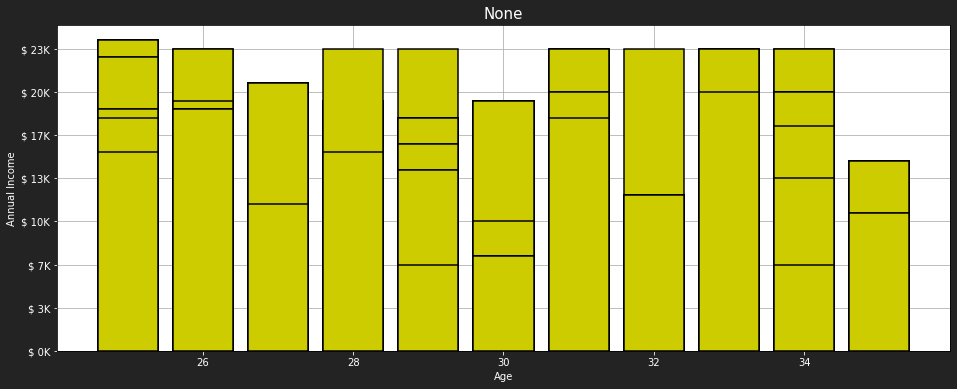

In [58]:
depend_for_income("Age")

People about 27 years old have the smallest earnings. The richest people 30 and 35 have the smallest maximum earnings. People aged 28 and 32 mostly have the maximum earnings relative to the entire sample.

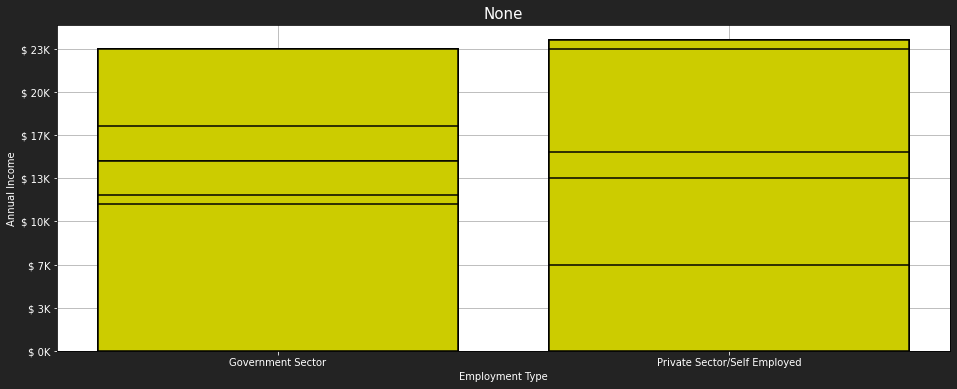

In [56]:
depend_for_income("Employment Type")

As expected, self-employed people are crossing the threshold of earnings of officially employed people. In addition, one-fourth of the self-employed have earnings like the richest officially employed people

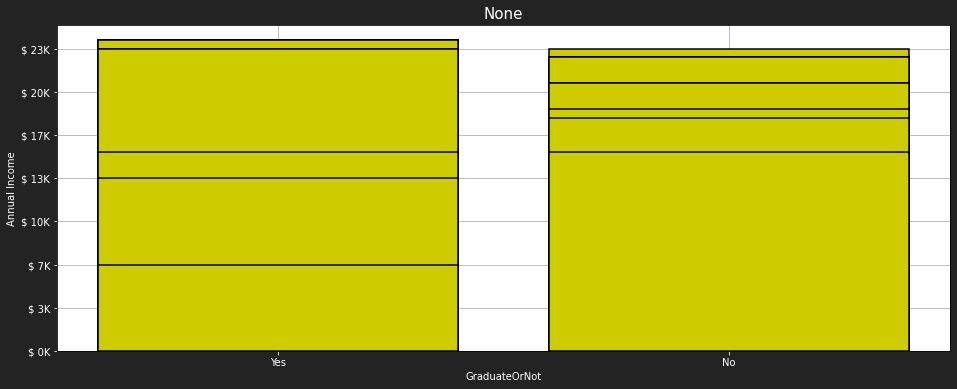

In [57]:
depend_for_income("GraduateOrNot")

We see that the vast majority of people who have not received a college education do not cross the average earnings threshold of the sample.  
You can also notice that graduates pass the maximum salary threshold, unlike non-graduates. And taking into account the fact of past visualization, it can be understood that people with education in this sample become self-employed with success

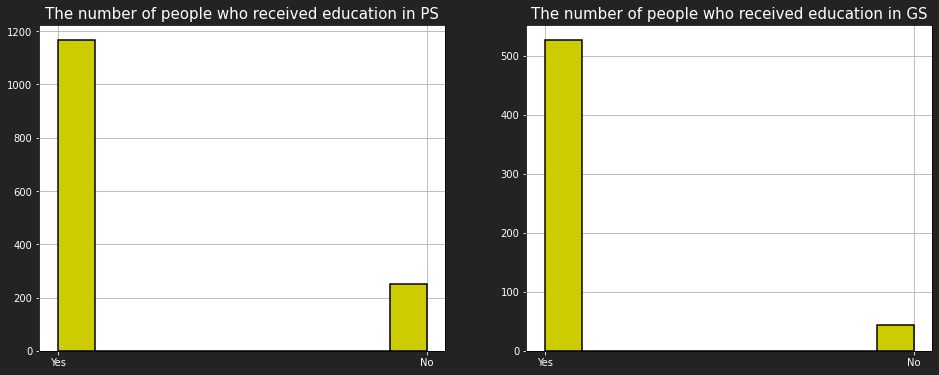

In [126]:
fig, (ax1,ax2) = plt.subplots(1,2)
gover_sector = data[data["Employment Type"] == "Government Sector"]
private_sector = data[data["Employment Type"] != "Government Sector"]
ax1.hist(private_sector["GraduateOrNot"])
ax1.set(title='The number of people who received education in PS')
ax2.hist(gover_sector["GraduateOrNot"])
ax2.set(title='The number of people who received education in GS')
plt.show()

In [431]:
def encoder(row):
    obj_cols = data.select_dtypes(include=['object']).columns
    if row.dtypes == "object":
        return LabelEncoder().fit_transform(row)
    return row

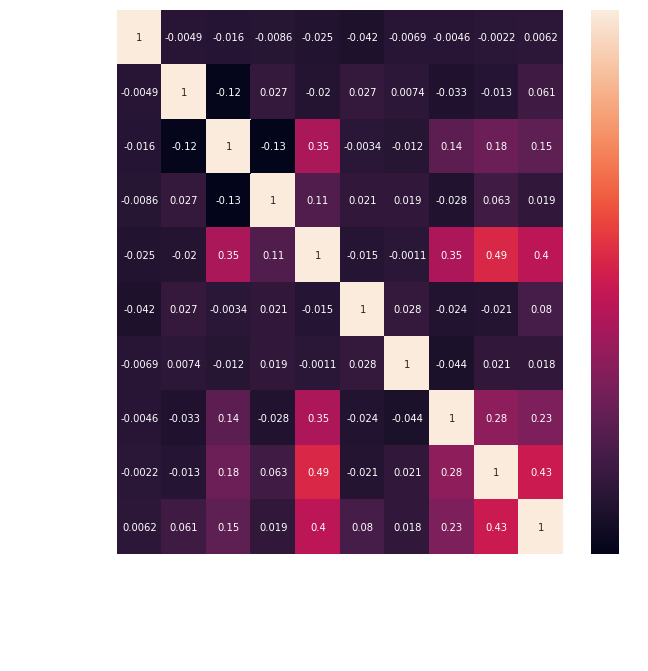

In [432]:
corr = data.apply(encoder).corr()
g = sns.heatmap(corr,annot=True)
g.figure.set_size_inches(10,10)

There is no highly correlating features

## Pre-processing

In [979]:
# Delete excess column
data = data.drop(data.columns[0], axis=1)

In [980]:
def pipeline_models(models: list=None) -> dict:   
    if not models:
        models = [RandomForestClassifier, LogisticRegression, GaussianProcessClassifier, 
                  AdaBoostClassifier, GradientBoostingClassifier, KNeighborsClassifier,
                  GaussianNB, xgb.XGBClassifier, LGBMClassifier]
    else:
        models = models
        
    for model in models:
        yield model
        
def preprocess(data):
    cat_cols = data.select_dtypes(include=['object']).columns
    # Drop target column
    num_cols = data.select_dtypes(include=['number']).columns[:-1]
    preprocessor = make_column_transformer((StandardScaler(), num_cols),
                                           (OneHotEncoder(), cat_cols))
    return preprocessor
def fit_pipe(model, X_train, X_test, y_train, y_test, preprocessor, **params):
        pipe = Pipeline([
        ("preproc", preprocessor),
        ("model", model(**params))
        ])
        with warnings.catch_warnings():  # Disable warnings
            warnings.simplefilter("ignore")
            pipe.fit(X_train, y_train)
            pred = pipe.predict_proba(X_test)[:,1]
        return roc_auc_score(y_test, pred), pipe

In [981]:
X = data.drop("TravelInsurance", axis=1)
y = data["TravelInsurance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46)

## Fitting a models

In [994]:
results = {}
for model in pipeline_models():
    acc, _ = fit_pipe(model, X_train, X_test, y_train, y_test, preprocess(data))
    results[type(model()).__name__] = acc

[15:18:17] WARNING: /private/var/folders/23/kp8g5yhx05qf9fjrh9p898240000gn/T/pip-install-bgwdvot2/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [995]:
import operator
sorted_tuples = sorted(results.items(), key=operator.itemgetter(1), reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}
for i, (k, v) in enumerate(sorted_dict.items()):
    print("{}. {} Accuracy -  {}\n".format(i+1, k, round(v, 5)))

1. GradientBoostingClassifier Accuracy -  0.80406

2. AdaBoostClassifier Accuracy -  0.8037

3. LGBMClassifier Accuracy -  0.79808

4. GaussianProcessClassifier Accuracy -  0.79781

5. LogisticRegression Accuracy -  0.79674

6. XGBClassifier Accuracy -  0.79381

7. RandomForestClassifier Accuracy -  0.78721

8. KNeighborsClassifier Accuracy -  0.77506

9. GaussianNB Accuracy -  0.77463



In [984]:
help(GradientBoostingClassifier)

Help on class GradientBoostingClassifier in module sklearn.ensemble._gb:

class GradientBoostingClassifier(sklearn.base.ClassifierMixin, BaseGradientBoosting)
 |  GradientBoostingClassifier(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
 |  
 |  Gradient Boosting for classification.
 |  
 |  GB builds an additive model in a
 |  forward stage-wise fashion; it allows for the optimization of
 |  arbitrary differentiable loss functions. In each stage ``n_classes_``
 |  regression trees are fit on the negative gradient of the
 |  binomial or multinomial deviance loss function. Binary classification
 |  is a special

In [996]:
n_rate_est = []
for i in range(50):
    n_rate_est.append(preproces_eval(X_train, X_test, y_train, y_test, 
                             GradientBoostingClassifier, **{"n_estimators": i+100}))
                       

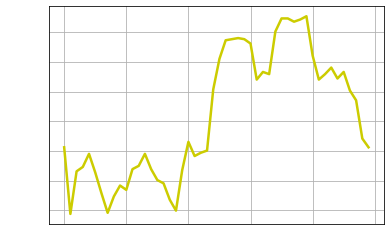

In [997]:
fig, ax = plt.subplots()
ax.plot(n_rait_est)
formatter = FuncFormatter(lambda x,p: int(x+100))
ax.xaxis.set_major_formatter(formatter)
plt.show()

In [998]:
dict(sorted([(pos+100, v) for pos, v in enumerate(n_rait_est)], key=lambda x: x[1], reverse=True))

{139: 0.8062741846323938,
 135: 0.8062373318592224,
 136: 0.8062373318592224,
 138: 0.8062189054726367,
 137: 0.8061820526994657,
 134: 0.8060162152201953,
 128: 0.8059056569006817,
 129: 0.8058872305140963,
 127: 0.805887230514096,
 126: 0.8058688041275106,
 130: 0.8058135249677539,
 140: 0.8056108347153124,
 125: 0.8055555555555555,
 143: 0.8054081444628708,
 132: 0.8053344389165285,
 145: 0.8053344389165285,
 133: 0.8052975861433572,
 142: 0.8052975861433572,
 144: 0.8052238805970149,
 141: 0.8052054542104294,
 131: 0.8052054542104293,
 124: 0.805039616731159,
 146: 0.8050211903445734,
 147: 0.8048553528653031,
 148: 0.8042104293348074,
 120: 0.8041551501750507,
 100: 0.8040630182421227,
 149: 0.8040630182421227,
 123: 0.8040077390823659,
 122: 0.8039708863091948,
 104: 0.8039524599226092,
 113: 0.8039524599226091,
 121: 0.8039156071494381,
 112: 0.8037497696701678,
 103: 0.8037313432835822,
 111: 0.8036944905104109,
 114: 0.8036944905104109,
 119: 0.8036760641238254,
 102: 0.803657

But these data tell us little. You should look at the effectiveness of hyperparameters in conjunction with others, and not separately. But on the other hand, we should not choose the best hyperparameters for the sample, because we will train it to predict almost indentical data well

In [1012]:
# After a quick grid search has been performed
best_result, model = preproces_eval(X_train, X_test, y_train, y_test,
                             GradientBoostingClassifier, meta=True, 
                                    **{"max_features":'sqrt',
                                       "subsample": .6,
                                       "min_weight_fraction_leaf": .08,
                                       "min_impurity_decrease": .06,
                                       })

In [1013]:
best_result

0.8108715680854985

In [993]:
model.named_steps['model'].feature_importances_

array([0.16894489, 0.50622798, 0.1027044 , 0.00831014, 0.00736843,
       0.00515297, 0.00488627, 0.00283284, 0.01779286, 0.00698858,
       0.05356323, 0.11522742])